# Pruebas con tests estadísticos para comprobar el salto térmico

In [1]:
import numpy as np
import pandas as pd
import pickle
import scipy.stats as stats
from scipy.stats import ttest_rel, shapiro, wilcoxon, t
import matplotlib.pyplot as plt
import pingouin as pg

In [2]:
fecha_ref = pd.Timestamp('2025-01-01 00:00:00').floor('d')

In [3]:
with open("../procData/muestras_ovul_tend.pkl", "rb") as f:
    muestras_tendencia = pickle.load(f)

In [4]:
with open("../procData/muestras_ovul_horas_norm1.pkl", "rb") as f:
    muestras_alin = pickle.load(f)

In [5]:
with open("../procData/muestras_ovul_horas_norm2.pkl", "rb") as f:
    muestras_norm = pickle.load(f)

In [6]:
# Definir rangos de días para probar
dias_antes = [-3, -2, -1, 0]   
dias_despues = [3, 4, 5, 6]

## Con intervalos máximos

In [7]:
intervalo_maximos = [21, 3]

### Datos alineados

In [12]:
def media_intervalo_horas(df, fecha_ref, inicio_hora, fin_hora):
    df = df.copy()
    df["dias_rel"] = (df["resultTimestamp"] - fecha_ref) / pd.Timedelta(days=1)
    df["hora"] = df["resultTimestamp"].dt.hour
    df["fecha"] = df["resultTimestamp"].dt.date

    # Filtro intervalo horario (considera cruce de medianoche)
    if inicio_hora > fin_hora:
        filtro = (df["hora"] >= inicio_hora) | (df["hora"] <= fin_hora)
    else:
        filtro = (df["hora"] >= inicio_hora) & (df["hora"] <= fin_hora)
    df_filtrado = df[filtro].copy()

    # Ajuste para horas después de medianoche (asignar al día anterior)
    df_filtrado.loc[df_filtrado["hora"] <= inicio_hora, "dias_rel"] -= 1

    df_filtrado["dia_entero"] = np.floor(df_filtrado["dias_rel"]).astype(int) + 1

    medias_intervalo = df_filtrado.groupby("dia_entero")["result"].mean()

    return medias_intervalo


resultados_alin = []

for dia_antes in dias_antes:
    for dia_despues in dias_despues:
        valores_antes = []
        valores_despues = []

        for key, data in muestras_alin.items():
            df = data["serie"].copy()
            # Obtener medias en intervalo horario (21:00 - 3:00)
            medias_intervalo = media_intervalo_horas(df, fecha_ref, intervalo_maximos[0], intervalo_maximos[1])

            val_antes = medias_intervalo.get(dia_antes, np.nan)
            val_despues = medias_intervalo.get(dia_despues, np.nan)

            if not (np.isnan(val_antes) or np.isnan(val_despues)):
                valores_antes.append(val_antes)
                valores_despues.append(val_despues)

        valores_antes = np.array(valores_antes)
        valores_despues = np.array(valores_despues)
        diferencias = valores_despues - valores_antes

        # Wilcoxon test para ascenso (antes < despues)
        stat_wil, p_wil = wilcoxon(valores_antes, valores_despues, alternative='less')

        # Shapiro para normalidad diferencias
        stat_shap, p_shap = shapiro(diferencias)

        # Test t pareado si normalidad aceptada
        if p_shap > 0.05:
            stat_t, p_t = ttest_rel(valores_despues, valores_antes)
        else:
            stat_t, p_t = np.nan, np.nan

        # Media e intervalo de confianza de la diferencia
        media_dif = np.mean(diferencias)
        std_dif = np.std(diferencias, ddof=1)
        n = len(diferencias)

        alpha = 0.05
        t_crit = t.ppf(1 - alpha/2, df=n-1)
        error_estandar = std_dif / np.sqrt(n)
        ic_inf = media_dif - t_crit * error_estandar
        ic_sup = media_dif + t_crit * error_estandar

        resultados_alin.append({
            "dia_antes": dia_antes,
            "dia_despues": dia_despues,
            "wilcoxon_p": p_wil,
            "shapiro_p": p_shap,
            "ttest_p": p_t,
            "media_dif": media_dif,
            "std_err": error_estandar,
            "int_conf_inf": ic_inf,
            "int_conf_sup": ic_sup
        })

df_resultados_alin = pd.DataFrame(resultados_alin)

print("Top resultados ordenados por p-valor Wilcoxon:")
print(df_resultados_alin.sort_values("wilcoxon_p").head(10)[
    ["dia_antes", "dia_despues", "wilcoxon_p", "shapiro_p", "ttest_p", "media_dif", "std_err", "int_conf_inf", "int_conf_sup"]
])


Top resultados ordenados por p-valor Wilcoxon:
    dia_antes  dia_despues    wilcoxon_p  shapiro_p   ttest_p  media_dif  \
5          -2            4  9.158619e-08   0.020911       NaN   0.113053   
1          -3            4  9.196637e-07   0.158383  0.000001   0.109937   
0          -3            3  1.855815e-06   0.000082       NaN   0.073022   
9          -1            4  2.225066e-06   0.570766  0.000001   0.101027   
7          -2            6  4.227909e-06   0.361213  0.000003   0.101887   
4          -2            3  5.216045e-06   0.000741       NaN   0.076138   
6          -2            5  7.121342e-06   0.437111  0.000011   0.099097   
3          -3            6  7.892384e-06   0.584879  0.000009   0.098770   
2          -3            5  1.001274e-05   0.690475  0.000010   0.095981   
11         -1            6  1.266884e-05   0.753876  0.000009   0.089860   

     std_err  int_conf_inf  int_conf_sup  
5   0.019102      0.074817      0.151290  
1   0.020246      0.069411    

### Series normalizadas
En este caso las mediciones concretas del salto no son representativas, pero sí la evidencia estadística del mismo

In [9]:
def media_intervalo_horas(df, fecha_ref, inicio_hora, fin_hora):
    df = df.copy()
    df["dias_rel"] = (df["resultTimestamp"] - fecha_ref) / pd.Timedelta(days=1)
    df["hora"] = df["resultTimestamp"].dt.hour
    df["fecha"] = df["resultTimestamp"].dt.date

    # Filtro intervalo horario (considera cruce de medianoche)
    if inicio_hora > fin_hora:
        filtro = (df["hora"] >= inicio_hora) | (df["hora"] <= fin_hora)
    else:
        filtro = (df["hora"] >= inicio_hora) & (df["hora"] <= fin_hora)
    df_filtrado = df[filtro].copy()

    # Ajuste para horas después de medianoche (asignar al día anterior)
    df_filtrado.loc[df_filtrado["hora"] <= inicio_hora, "dias_rel"] -= 1

    df_filtrado["dia_entero"] = np.floor(df_filtrado["dias_rel"]).astype(int) + 1

    medias_intervalo = df_filtrado.groupby("dia_entero")["result"].mean()

    return medias_intervalo


resultados_norm = []

for dia_antes in dias_antes:
    for dia_despues in dias_despues:
        valores_antes = []
        valores_despues = []

        for key, data in muestras_norm.items():
            df = data["serie"].copy()
            # Obtener medias en intervalo horario (21:00 - 3:00)
            medias_intervalo = media_intervalo_horas(df, fecha_ref, intervalo_maximos[0], intervalo_maximos[1])

            val_antes = medias_intervalo.get(dia_antes, np.nan)
            val_despues = medias_intervalo.get(dia_despues, np.nan)

            if not (np.isnan(val_antes) or np.isnan(val_despues)):
                valores_antes.append(val_antes)
                valores_despues.append(val_despues)

        valores_antes = np.array(valores_antes)
        valores_despues = np.array(valores_despues)
        diferencias = valores_despues - valores_antes

        # Wilcoxon test para ascenso (antes < despues)
        stat_wil, p_wil = wilcoxon(valores_antes, valores_despues, alternative='less')

        # Shapiro para normalidad diferencias
        stat_shap, p_shap = shapiro(diferencias)

        # Test t pareado si normalidad aceptada
        if p_shap > 0.05:
            stat_t, p_t = ttest_rel(valores_despues, valores_antes)
        else:
            stat_t, p_t = np.nan, np.nan

        # Media e intervalo de confianza de la diferencia
        media_dif = np.mean(diferencias)
        std_dif = np.std(diferencias, ddof=1)
        n = len(diferencias)

        alpha = 0.05
        t_crit = t.ppf(1 - alpha/2, df=n-1)
        error_estandar = std_dif / np.sqrt(n)
        ic_inf = media_dif - t_crit * error_estandar
        ic_sup = media_dif + t_crit * error_estandar

        resultados_norm.append({
            "dia_antes": dia_antes,
            "dia_despues": dia_despues,
            "wilcoxon_p": p_wil,
            "shapiro_p": p_shap,
            "ttest_p": p_t,
            "media_dif": media_dif,
            "std_err": error_estandar,
            "int_conf_inf": ic_inf,
            "int_conf_sup": ic_sup
        })

df_resultados_norm = pd.DataFrame(resultados_norm)

print("Top resultados ordenados por p-valor Wilcoxon:")
print(df_resultados_norm.sort_values("wilcoxon_p").head(10)[
    ["dia_antes", "dia_despues", "wilcoxon_p", "shapiro_p", "ttest_p", "media_dif", "std_err", "int_conf_inf", "int_conf_sup"]
])


Top resultados ordenados por p-valor Wilcoxon:
    dia_antes  dia_despues    wilcoxon_p  shapiro_p       ttest_p  media_dif  \
5          -2            4  1.428654e-07   0.357506  1.105583e-07   0.719552   
1          -3            4  1.067911e-06   0.982060  4.705104e-07   0.704402   
9          -1            4  1.384212e-06   0.284074  4.088596e-07   0.656339   
0          -3            3  1.436159e-06   0.008915           NaN   0.511828   
6          -2            5  2.479374e-06   0.618345  2.734923e-06   0.689172   
2          -3            5  3.185472e-06   0.947898  1.257189e-06   0.674021   
4          -2            3  4.379128e-06   0.023921           NaN   0.526978   
7          -2            6  6.880695e-06   0.572051  4.407493e-06   0.667740   
3          -3            6  8.742610e-06   0.431706  9.990307e-06   0.652589   
11         -1            6  1.071191e-05   0.163248  6.588838e-06   0.604527   

     std_err  int_conf_inf  int_conf_sup  
5   0.118835      0.481679   

c:\Users\pablo\AppData\Local\Programs\Python\Python313\Lib\site-packages\pingouin\plotting.py:573: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["wthn"] = data[within].replace({_ordr: i for i, _ordr in enumerate(order)})


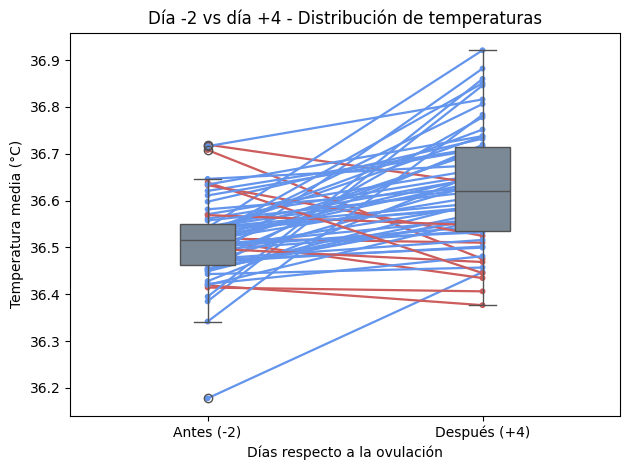

In [13]:
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
import numpy as np

# Escoge la combinación que quieres visualizar
dia_antes = -2
dia_despues = 4

# Preparar los valores para esa combinación concreta
valores_antes = []
valores_despues = []

for key, data in muestras_alin.items():
    df = data["serie"].copy()
    medias_intervalo = media_intervalo_horas(df, fecha_ref, intervalo_maximos[0], intervalo_maximos[1])

    val_antes = medias_intervalo.get(dia_antes, np.nan)
    val_despues = medias_intervalo.get(dia_despues, np.nan)

    if not (np.isnan(val_antes) or np.isnan(val_despues)):
        valores_antes.append(val_antes)
        valores_despues.append(val_despues)

valores_antes = np.array(valores_antes)
valores_despues = np.array(valores_despues)

# Crear DataFrame en formato long
df_plot = pd.DataFrame({
    "Subject": np.tile(np.arange(len(valores_antes)), 2),
    "Condition": ["Antes (-2)"] * len(valores_antes) + ["Después (+4)"] * len(valores_despues),
    "Value": np.concatenate([valores_antes, valores_despues])
})

# Gráfico pareado con colores para menor, igual, mayor
fig = pg.plot_paired(
    data=df_plot,
    dv="Value",
    within="Condition",
    subject="Subject",
    boxplot=True,
    colors=["cornflowerblue", "gray", "indianred"]
)

plt.title(f"Día {dia_antes} vs día +{dia_despues} - Distribución de temperaturas")
plt.ylabel("Temperatura media (°C)")
plt.xlabel("Días respecto a la ovulación")
plt.tight_layout()
plt.show()


## Con intervalos mínimos

In [14]:
intervalo_minimos = [7, 15]

### Series alineadas

In [15]:
def media_intervalo_horas(df, fecha_ref, inicio_hora, fin_hora):
    df = df.copy()
    df["dias_rel"] = (df["resultTimestamp"] - fecha_ref) / pd.Timedelta(days=1)
    df["hora"] = df["resultTimestamp"].dt.hour
    df["fecha"] = df["resultTimestamp"].dt.date

    # Filtro intervalo horario (considera cruce de medianoche)
    if inicio_hora > fin_hora:
        filtro = (df["hora"] >= inicio_hora) | (df["hora"] <= fin_hora)
    else:
        filtro = (df["hora"] >= inicio_hora) & (df["hora"] <= fin_hora)
    df_filtrado = df[filtro].copy()

    # Ajuste para horas después de medianoche (asignar al día anterior)
    df_filtrado.loc[df_filtrado["hora"] <= inicio_hora, "dias_rel"] -= 1

    df_filtrado["dia_entero"] = np.floor(df_filtrado["dias_rel"]).astype(int)

    medias_intervalo = df_filtrado.groupby("dia_entero")["result"].mean()

    return medias_intervalo


resultados_alin = []

for dia_antes in dias_antes:
    for dia_despues in dias_despues:
        valores_antes = []
        valores_despues = []

        for key, data in muestras_alin.items():
            df = data["serie"].copy()
            # Obtener medias en intervalo horario (21:00 - 3:00)
            medias_intervalo = media_intervalo_horas(df, fecha_ref, intervalo_minimos[0], intervalo_minimos[1])

            val_antes = medias_intervalo.get(dia_antes, np.nan)
            val_despues = medias_intervalo.get(dia_despues, np.nan)

            if not (np.isnan(val_antes) or np.isnan(val_despues)):
                valores_antes.append(val_antes)
                valores_despues.append(val_despues)

        valores_antes = np.array(valores_antes)
        valores_despues = np.array(valores_despues)
        diferencias = valores_despues - valores_antes

        # Wilcoxon test para ascenso (antes < despues)
        stat_wil, p_wil = wilcoxon(valores_antes, valores_despues, alternative='less')

        # Shapiro para normalidad diferencias
        stat_shap, p_shap = shapiro(diferencias)

        # Test t pareado si normalidad aceptada
        if p_shap > 0.05:
            stat_t, p_t = ttest_rel(valores_despues, valores_antes)
        else:
            stat_t, p_t = np.nan, np.nan

        # Media e intervalo de confianza de la diferencia
        media_dif = np.mean(diferencias)
        std_dif = np.std(diferencias, ddof=1)
        n = len(diferencias)

        alpha = 0.05
        t_crit = t.ppf(1 - alpha/2, df=n-1)
        error_estandar = std_dif / np.sqrt(n)
        ic_inf = media_dif - t_crit * error_estandar
        ic_sup = media_dif + t_crit * error_estandar

        resultados_alin.append({
            "dia_antes": dia_antes,
            "dia_despues": dia_despues,
            "wilcoxon_p": p_wil,
            "shapiro_p": p_shap,
            "ttest_p": p_t,
            "media_dif": media_dif,
            "std_err": error_estandar,
            "int_conf_inf": ic_inf,
            "int_conf_sup": ic_sup
        })

df_resultados_alin = pd.DataFrame(resultados_alin)

print("Top resultados ordenados por p-valor Wilcoxon:")
print(df_resultados_alin.sort_values("wilcoxon_p").head(10)[
    ["dia_antes", "dia_despues", "wilcoxon_p", "shapiro_p", "ttest_p", "media_dif", "std_err", "int_conf_inf", "int_conf_sup"]
])


Top resultados ordenados por p-valor Wilcoxon:
    dia_antes  dia_despues  wilcoxon_p  shapiro_p   ttest_p  media_dif  \
4          -2            3    0.004216   0.008803       NaN   0.062025   
6          -2            5    0.010042   0.866617  0.021168   0.041928   
7          -2            6    0.011545   0.290399  0.018862   0.037925   
5          -2            4    0.022739   0.793226  0.036674   0.039665   
0          -3            3    0.041951   0.690829  0.067550   0.037376   
8          -1            3    0.043320   0.011718       NaN   0.045405   
10         -1            5    0.097100   0.260483  0.179042   0.025308   
2          -3            5    0.127196   0.502866  0.306463   0.017279   
11         -1            6    0.161384   0.474747  0.244103   0.021305   
3          -3            6    0.163238   0.649975  0.438826   0.013276   

     std_err  int_conf_inf  int_conf_sup  
4   0.021501      0.018987      0.105063  
6   0.017696      0.006506      0.077350  
7   0.015

### Series normalizadas

In [16]:
def media_intervalo_horas(df, fecha_ref, inicio_hora, fin_hora):
    df = df.copy()
    df["dias_rel"] = (df["resultTimestamp"] - fecha_ref) / pd.Timedelta(days=1)
    df["hora"] = df["resultTimestamp"].dt.hour
    df["fecha"] = df["resultTimestamp"].dt.date

    # Filtro intervalo horario (considera cruce de medianoche)
    if inicio_hora > fin_hora:
        filtro = (df["hora"] >= inicio_hora) | (df["hora"] <= fin_hora)
    else:
        filtro = (df["hora"] >= inicio_hora) & (df["hora"] <= fin_hora)
    df_filtrado = df[filtro].copy()

    # Ajuste para horas después de medianoche (asignar al día anterior)
    df_filtrado.loc[df_filtrado["hora"] <= inicio_hora, "dias_rel"] -= 1

    df_filtrado["dia_entero"] = np.floor(df_filtrado["dias_rel"]).astype(int)

    medias_intervalo = df_filtrado.groupby("dia_entero")["result"].mean()

    return medias_intervalo


resultados_norm = []

for dia_antes in dias_antes:
    for dia_despues in dias_despues:
        valores_antes = []
        valores_despues = []

        for key, data in muestras_norm.items():
            df = data["serie"].copy()
            # Obtener medias en intervalo horario (21:00 - 3:00)
            medias_intervalo = media_intervalo_horas(df, fecha_ref, intervalo_minimos[0], intervalo_minimos[1])

            val_antes = medias_intervalo.get(dia_antes, np.nan)
            val_despues = medias_intervalo.get(dia_despues, np.nan)

            if not (np.isnan(val_antes) or np.isnan(val_despues)):
                valores_antes.append(val_antes)
                valores_despues.append(val_despues)

        valores_antes = np.array(valores_antes)
        valores_despues = np.array(valores_despues)
        diferencias = valores_despues - valores_antes

        # Wilcoxon test para ascenso (antes < despues)
        stat_wil, p_wil = wilcoxon(valores_antes, valores_despues, alternative='less')

        # Shapiro para normalidad diferencias
        stat_shap, p_shap = shapiro(diferencias)

        # Test t pareado si normalidad aceptada
        if p_shap > 0.05:
            stat_t, p_t = ttest_rel(valores_despues, valores_antes)
        else:
            stat_t, p_t = np.nan, np.nan

        # Media e intervalo de confianza de la diferencia
        media_dif = np.mean(diferencias)
        std_dif = np.std(diferencias, ddof=1)
        n = len(diferencias)

        alpha = 0.05
        t_crit = t.ppf(1 - alpha/2, df=n-1)
        error_estandar = std_dif / np.sqrt(n)
        ic_inf = media_dif - t_crit * error_estandar
        ic_sup = media_dif + t_crit * error_estandar

        resultados_norm.append({
            "dia_antes": dia_antes,
            "dia_despues": dia_despues,
            "wilcoxon_p": p_wil,
            "shapiro_p": p_shap,
            "ttest_p": p_t,
            "media_dif": media_dif,
            "std_err": error_estandar,
            "int_conf_inf": ic_inf,
            "int_conf_sup": ic_sup
        })

df_resultados_norm = pd.DataFrame(resultados_norm)

print("Top resultados ordenados por p-valor Wilcoxon:")
print(df_resultados_norm.sort_values("wilcoxon_p").head(10)[
    ["dia_antes", "dia_despues", "wilcoxon_p", "shapiro_p", "ttest_p", "media_dif", "std_err", "int_conf_inf", "int_conf_sup"]
])


Top resultados ordenados por p-valor Wilcoxon:
    dia_antes  dia_despues  wilcoxon_p  shapiro_p   ttest_p  media_dif  \
4          -2            3    0.004311   0.287073  0.006572   0.379543   
6          -2            5    0.009645   0.761835  0.014637   0.300654   
7          -2            6    0.010453   0.901958  0.017388   0.254603   
5          -2            4    0.023149   0.839008  0.042530   0.248521   
8          -1            3    0.047648   0.099127  0.040386   0.254027   
0          -3            3    0.057337   0.865632  0.091674   0.216521   
2          -3            5    0.109289   0.444976  0.235989   0.137633   
10         -1            5    0.127196   0.100040  0.152117   0.175139   
11         -1            6    0.180541   0.636442  0.261274   0.129088   
3          -3            6    0.180541   0.462485  0.423823   0.091582   

     std_err  int_conf_inf  int_conf_sup  
4   0.134615      0.110080      0.649005  
6   0.119468      0.061512      0.539795  
7   0.103

### Tendencia de las series

In [ ]:
def media_intervalo_horas(df, fecha_ref, inicio_hora, fin_hora):
    df = df.copy()
    df["dias_rel"] = (df["resultTimestamp"] - fecha_ref) / pd.Timedelta(days=1)
    df["hora"] = df["resultTimestamp"].dt.hour
    df["fecha"] = df["resultTimestamp"].dt.date

    # Filtro intervalo horario (considera cruce de medianoche)
    if inicio_hora > fin_hora:
        filtro = (df["hora"] >= inicio_hora) | (df["hora"] <= fin_hora)
    else:
        filtro = (df["hora"] >= inicio_hora) & (df["hora"] <= fin_hora)
    df_filtrado = df[filtro].copy()

    # Ajuste para horas después de medianoche (asignar al día anterior)
    df_filtrado.loc[df_filtrado["hora"] <= inicio_hora, "dias_rel"] -= 1

    df_filtrado["dia_entero"] = np.floor(df_filtrado["dias_rel"]).astype(int)

    medias_intervalo = df_filtrado.groupby("dia_entero")["tendencia"].mean()

    return medias_intervalo


resultados_tend = []

for dia_antes in dias_antes:
    for dia_despues in dias_despues:
        valores_antes = []
        valores_despues = []

        for key, data in muestras_tendencia.items():
            df = data["serie"].copy()
            # Obtener medias en intervalo horario (21:00 - 3:00)
            medias_intervalo = media_intervalo_horas(df, fecha_ref, intervalo_minimos[0], intervalo_minimos[1])

            val_antes = medias_intervalo.get(dia_antes, np.nan)
            val_despues = medias_intervalo.get(dia_despues, np.nan)

            if not (np.isnan(val_antes) or np.isnan(val_despues)):
                valores_antes.append(val_antes)
                valores_despues.append(val_despues)

        valores_antes = np.array(valores_antes)
        valores_despues = np.array(valores_despues)
        diferencias = valores_despues - valores_antes

        # Wilcoxon test para ascenso (antes < despues)
        stat_wil, p_wil = wilcoxon(valores_antes, valores_despues, alternative='less')

        # Shapiro para normalidad diferencias
        stat_shap, p_shap = shapiro(diferencias)

        # Test t pareado si normalidad aceptada
        if p_shap > 0.05:
            stat_t, p_t = ttest_rel(valores_despues, valores_antes)
        else:
            stat_t, p_t = np.nan, np.nan

        # Media e intervalo de confianza de la diferencia
        media_dif = np.mean(diferencias)
        std_dif = np.std(diferencias, ddof=1)
        n = len(diferencias)

        alpha = 0.05
        t_crit = t.ppf(1 - alpha/2, df=n-1)
        error_estandar = std_dif / np.sqrt(n)
        ic_inf = media_dif - t_crit * error_estandar
        ic_sup = media_dif + t_crit * error_estandar

        resultados_tend.append({
            "dia_antes": dia_antes,
            "dia_despues": dia_despues,
            "wilcoxon_p": p_wil,
            "shapiro_p": p_shap,
            "ttest_p": p_t,
            "media_dif": media_dif,
            "std_err": error_estandar,
            "int_conf_inf": ic_inf,
            "int_conf_sup": ic_sup
        })

df_resultados_tend = pd.DataFrame(resultados_tend)

print("Top resultados ordenados por p-valor Wilcoxon:")
print(df_resultados_tend.sort_values("wilcoxon_p").head(10)[
    ["dia_antes", "dia_despues", "wilcoxon_p", "shapiro_p", "ttest_p", "media_dif", "std_err", "int_conf_inf", "int_conf_sup"]
])


Top resultados ordenados por p-valor Wilcoxon:
    dia_antes  dia_despues    wilcoxon_p  shapiro_p       ttest_p  media_dif  \
3          -3            6  3.828273e-07   0.779237  7.415681e-08   0.068565   
7          -2            6  5.591863e-06   0.664837  1.527622e-06   0.059808   
2          -3            5  1.145740e-05   0.764389  8.911772e-06   0.052924   
0          -3            3  1.447460e-05   0.650828  1.392071e-05   0.050685   
1          -3            4  1.707699e-05   0.609419  1.992470e-05   0.046257   
4          -2            3  4.203428e-05   0.442617  9.073326e-05   0.041928   
6          -2            5  1.732886e-04   0.944517  3.488472e-04   0.044167   
5          -2            4  2.888464e-04   0.550080  3.911563e-04   0.037500   
11         -1            6  1.920856e-03   0.358263  1.455702e-03   0.039428   
15          0            6  5.484766e-03   0.793013  4.527339e-03   0.030321   

     std_err  int_conf_inf  int_conf_sup  
3   0.011131      0.046284   